# Multiclass Classification

This notebook explores multiclass classification

In [3]:
import numpy as np
import plotsandgraphs as pandg
%load_ext autoreload
%autoreload 2

### Create some dummy data

In [374]:
num_classes = 3
class_labels = np.arange(num_classes)
class_probs = np.random.random(num_classes)
class_probs = class_probs / class_probs.sum() # normalize
# True labels
y_true = np.random.choice(class_labels, p=class_probs, size=1000)
# one hot encoding
y_true_one_hot = np.eye(num_classes)[y_true] 

# Predicted labels
y_pred = np.ones(y_true_one_hot.shape)

# parameters for Beta distribution for each label
a0, b0 = [0.1, 0.6, 0.3, 0.4, 2],  [0.4, 1.2, 0.8, 1, 5]
a1, b1 = [0.9, 0.8, 0.9, 1.2, 5],  [0.4, 0.1, 0.5, 0.3, 2]

# iterate through all the columns/labels and create a beta distribution for each label
for i in range(y_pred.shape[1]):
    y = y_pred[:, i]
    y_t = y_true_one_hot[:, i]
    y[y_t==0] = np.random.beta(a0[i], b0[i], size=y[y_t==0].shape)
    y[y_t==1] = np.random.beta(a1[i], b1[i], size=y[y_t==1].shape)
y_pred.shape

(1000, 3)

### Histogram of probabilities

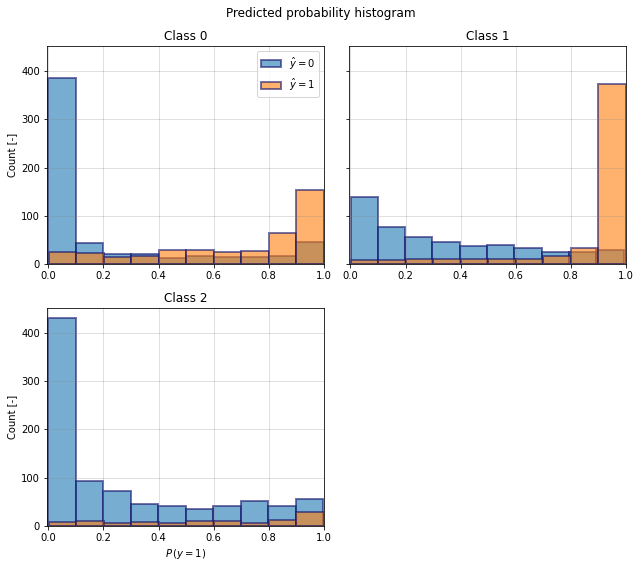

In [375]:
fig = pandg.multiclass_classifier.plot_y_prob_histogram(y_true_one_hot, y_pred)

In [255]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from tqdm import tqdm
import matplotlib.pyplot as plt
from plotsandgraphs.utils import bootstrap

ROC for Class:   0%|          | 0/5 [00:00<?, ?it/s]

ROC for Class: 100%|██████████| 5/5 [00:00<00:00, 14.50it/s]


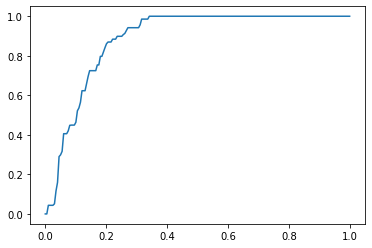

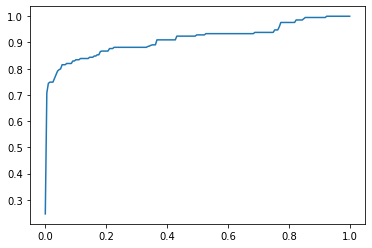

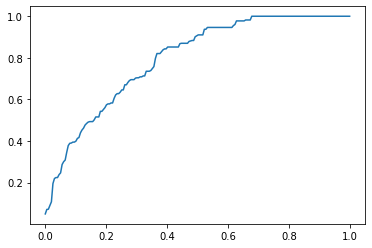

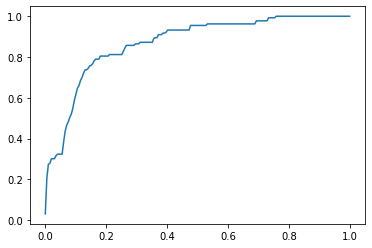

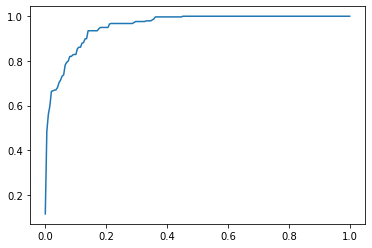

In [256]:
# def auroc_metric_function(y_true, y_score, average, multi_class):
#     auc = roc_auc_score(y_true, y_score, average=average, multi_class=multi_class)
#     return auc

n_bootstraps = 1

def roc_metric_function(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score, drop_intermediate=False)
    auc_score = auc(fpr, tpr)
    # print lengths
    # print(fpr.shape, tpr.shape, auc_score)
    return fpr, tpr, auc_score

# for each class calculate the ROC
for i in tqdm(range(y_true_one_hot.shape[-1]), desc='ROC for Class'):
    # bootstrap the ROC curve for class i
    roc_result = bootstrap(
                    metric_function=roc_metric_function,
                    input_resample=[y_true_one_hot[:, i], y_pred[:, i]],
                    n_bootstraps=n_bootstraps, 
                    metric_kwargs={})
    # unpack the results
    fprs, tprs, aucs = zip(*roc_result)
    fprs, tprs, aucs = [x for x in [fprs, tprs, aucs]]
    
    # Determine min and max FPR values across all bootstrapped samples
    min_fpr = min(min(fpr) for fpr in fprs)
    max_fpr = max(max(fpr) for fpr in fprs)
    
    # Define common FPR values for interpolation within the min and max range
    common_fpr = np.linspace(min_fpr, max_fpr, 200)
    
    # Interpolate TPRs for each bootstrap sample
    interp_tprs = [np.interp(common_fpr, np.sort(fpr), tpr[np.argsort(fpr)]) for fpr, tpr in zip(fprs, tprs)]
    
    # calculate median and quantiles
    quantiles = [0.025, 0.5, 0.975]
    tpr_lower, tpr_median, tpr_upper = np.quantile(interp_tprs, q=quantiles, axis=0)
    
    plt.figure()
    plt.plot(common_fpr, tpr_median, label='Median ROC')
    plt.fill_between(common_fpr, tpr_lower, tpr_upper, alpha=0.2, label='95% CI')
    


Bootsrapping: 100%|██████████| 10/10 [00:00<00:00, 161.66it/s]


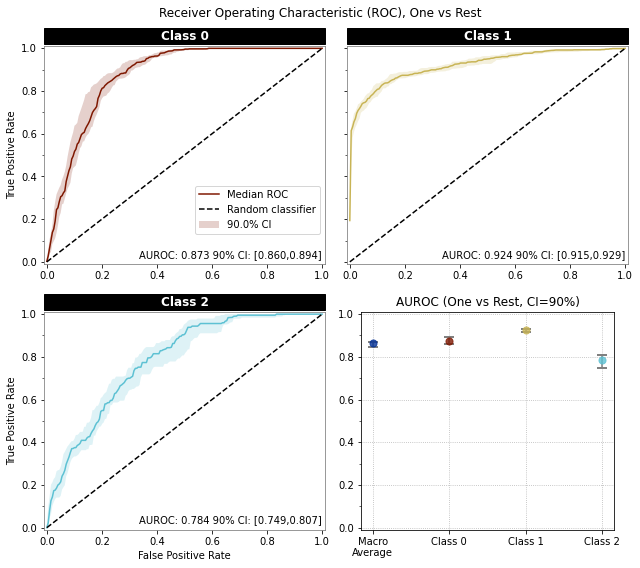

In [377]:
fig = pandg.multiclass_classifier.plot_roc_curve(y_true_one_hot, y_pred, n_bootstraps=10, highlight_roc_area=True, confidence_interval=0.9, save_fig_path='temp_figures/', split_plots=False)

C:\Users\joshu\LRZ_Sync_Share\Joshua\Programming\plots_and_graphs\plotsandgraphs\cmaps\roma.txt


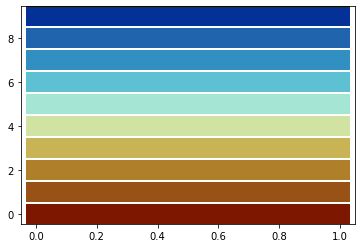

In [359]:
from plotsandgraphs.utils import get_cmap

cmap, colors = get_cmap('roma', 10)
for i in range(len(colors)):
    plt.plot([0, 1], [i, i], color=colors[i], lw=20, linestyle='-', label='Class {}'.format(i))